## Librerias necesarias
    ´´´python
    !pip install pandas
    !pip install seaborn
    ´´´

## Carga de datos: 
-Utiliza alguna biblioteca de análisis de datos en Python, como Pandas, para cargar los datos en un DataFrame. Asegúrate de que los datos estén en formato JSON o conviértelos a dicho formato si es necesario.

In [15]:
import os
from dotenv import load_dotenv
import pandas as pd
from sodapy import Socrata

# Cargar variables de entorno desde el archivo .env
load_dotenv()

# Obtener el token de la variable de entorno
app_token = os.getenv("APP_TOKEN")

# Verificar si el token está presente
if not app_token:
    raise ValueError("El token de la aplicación no está definido en el archivo .env")

# Inicializar el cliente Socrata con el app_token
cliente = Socrata('www.datos.gov.co', app_token, timeout=30)

# Definir el tamaño de la página
limit = 50000

# Inicializar el offset
offset = 0

# Contador para el nombre del archivo CSV
csv_count = 1

# Realizar solicitudes de forma repetida hasta que no haya más datos
while True:
    # Construir la consulta con la cláusula where para filtrar los datos desde el año 2020
    consulta = "departamento='CUNDINAMARCA' AND fechaobservacion >= '2023-01-01T00:00:00.000'"

    # Realizar la solicitud con la consulta construida
    result = cliente.get("sbwg-7ju4", where=consulta, limit=limit, offset=offset)

    # Verificar si hay resultados
    if len(result) == 0:
        break
    
    # Convertir los resultados en un DataFrame de Pandas
    df = pd.DataFrame.from_records(result)
    
    # Guardar los datos en un archivo CSV
    csv_filename = f"data_{csv_count}.csv"
    df.to_csv(csv_filename, index=False)
    
    # Incrementar el offset para la próxima solicitud
    offset += limit
    
    # Incrementar el contador de archivos CSV
    csv_count += 1


In [25]:
print(df.columns)


Index(['fechaobservacion', 'valorobservado', 'nombreestacion', 'departamento',
       'municipio', 'latitud', 'longitud', 'descripcionsensor'],
      dtype='object')


## Limpieza de datos: 
-Realiza tareas de limpieza de datos para asegurarte de que los datos estén en el formato correcto y no contengan valores nulos o incorrectos.

In [12]:
import os
import pandas as pd

# Directorio donde se encuentran los archivos CSV
directorio_csv = "/home/dev1/Documents/sergioarboleda/proyectoClima"

# Inicializar un DataFrame vacío para almacenar todos los datos
df_all = pd.DataFrame()

# Iterar sobre todos los archivos CSV en el directorio
for filename in os.listdir(directorio_csv):
    if filename.endswith(".csv"):
        # Leer el archivo CSV y cargar los datos en un DataFrame
        filepath = os.path.join(directorio_csv, filename)
        df = pd.read_csv(filepath)
        
        # Definir las columnas a mantener
        columnas_mantener = ['fechaobservacion', 'valorobservado', 'nombreestacion', 'departamento',
                             'municipio', 'latitud', 'longitud', 'descripcionsensor']
        
        # Eliminar las columnas que no están presentes en los datos
        columnas_a_eliminar = [col for col in df.columns if col not in columnas_mantener]
        df_clean = df.drop(columns=columnas_a_eliminar)
        
        # Convertir las columnas de fecha a tipo datetime
        df_clean['fechaobservacion'] = pd.to_datetime(df_clean['fechaobservacion'])
        
        # Convertir la columna 'valorobservado' a tipo numérico
        df_clean['valorobservado'] = pd.to_numeric(df_clean['valorobservado'], errors='coerce')
        
        # Eliminar filas con valores faltantes
        df_clean.dropna(inplace=True)
        
        # Agregar los datos limpios al DataFrame general
        df_all = pd.concat([df_all, df_clean], ignore_index=True)

# Guardar todos los datos limpios en un DataFrame en el mismo cuaderno
df_all.to_csv("datos_limpios_total.csv", index=False)

print("Limpieza de datos completada. Los datos limpios se han guardado en 'datos_limpios_total.csv'")



Limpieza de datos completada. Los datos limpios se han guardado en 'datos_limpios_total.csv'


# Análisis exploratorio de datos (EDA): 
-Explora tus datos para comprender mejor su distribución y características. Puedes visualizar la distribución de las temperaturas, identificar valores atípicos, y explorar la relación entre las variables.

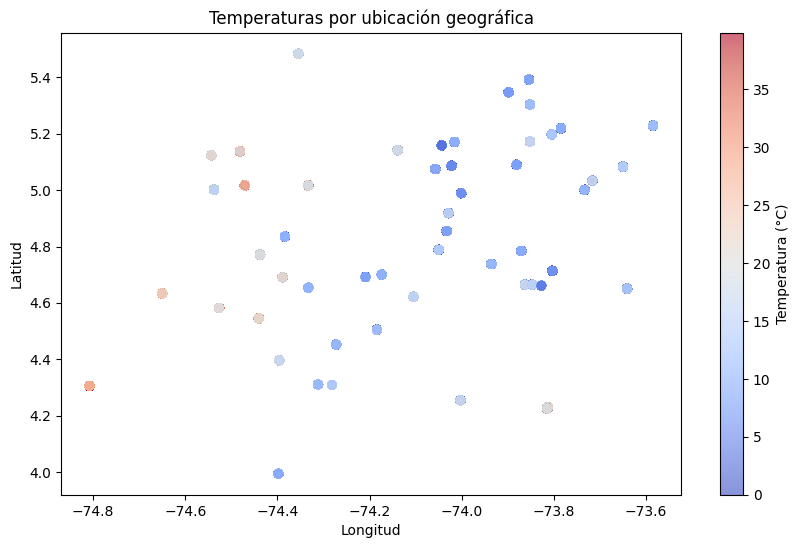

Valores atípicos:
           fechaobservacion  valorobservado               nombreestacion  \
17134   2024-01-06 06:10:00        1.664706                      EL OKAL   
17555   2024-01-06 06:20:00        1.598521                      EL OKAL   
17573   2024-01-06 06:00:00        1.793462                      EL OKAL   
25122   2024-01-09 04:40:00        1.744750                    IBERIA LA   
25195   2024-01-09 05:30:00        1.511817                    IBERIA LA   
...                     ...             ...                          ...   
2490028 2023-10-11 10:00:00       32.400000  UNIVERSIDAD DE CUNDINAMARCA   
2492775 2023-10-21 12:00:00       33.400000  UNIVERSIDAD DE CUNDINAMARCA   
2496129 2023-10-21 11:00:00       32.000000  UNIVERSIDAD DE CUNDINAMARCA   
2497680 2023-10-20 15:00:00       31.600000  UNIVERSIDAD DE CUNDINAMARCA   
2504187 2023-10-20 10:00:00       32.800000  UNIVERSIDAD DE CUNDINAMARCA   

         departamento   municipio   latitud   longitud  \
17134    CU

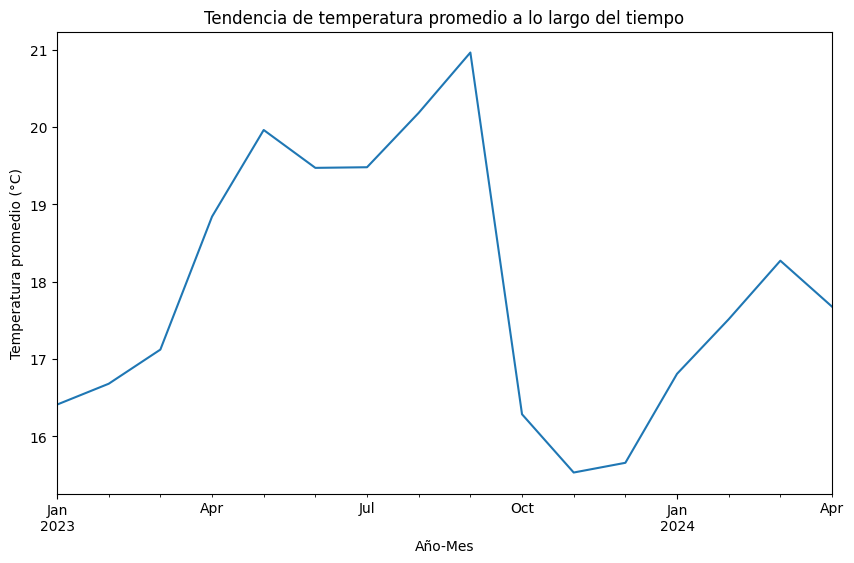

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos limpios desde el archivo CSV
df = pd.read_csv("datos_limpios_total.csv")

# Manejo de datos faltantes
df.dropna(inplace=True)

# Análisis de tendencias a lo largo del tiempo
df['fechaobservacion'] = pd.to_datetime(df['fechaobservacion'])  # Asegurarse de que 'fechaobservacion' es de tipo datetime
df['year'] = df['fechaobservacion'].dt.year
df['month'] = df['fechaobservacion'].dt.month

# Análisis por ubicación geográfica
plt.figure(figsize=(10, 6))
plt.scatter(df['longitud'], df['latitud'], c=df['valorobservado'], cmap='coolwarm', alpha=0.6)
plt.colorbar(label='Temperatura (°C)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Temperaturas por ubicación geográfica')
plt.show()

# Identificación de valores atípicos
Q1 = df['valorobservado'].quantile(0.25)
Q3 = df['valorobservado'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['valorobservado'] < Q1 - 1.5 * IQR) | (df['valorobservado'] > Q3 + 1.5 * IQR)]
print("Valores atípicos:")
print(outliers)

# Comparación de temperaturas promedio
plt.figure(figsize=(10, 6))
df['year_month'] = df['fechaobservacion'].dt.to_period('M')
df.groupby('year_month')['valorobservado'].mean().plot()
plt.xlabel('Año-Mes')
plt.ylabel('Temperatura promedio (°C)')
plt.title('Tendencia de temperatura promedio a lo largo del tiempo')
plt.show()



AttributeError: 'NoneType' object has no attribute 'set_bbox_to_anchor'

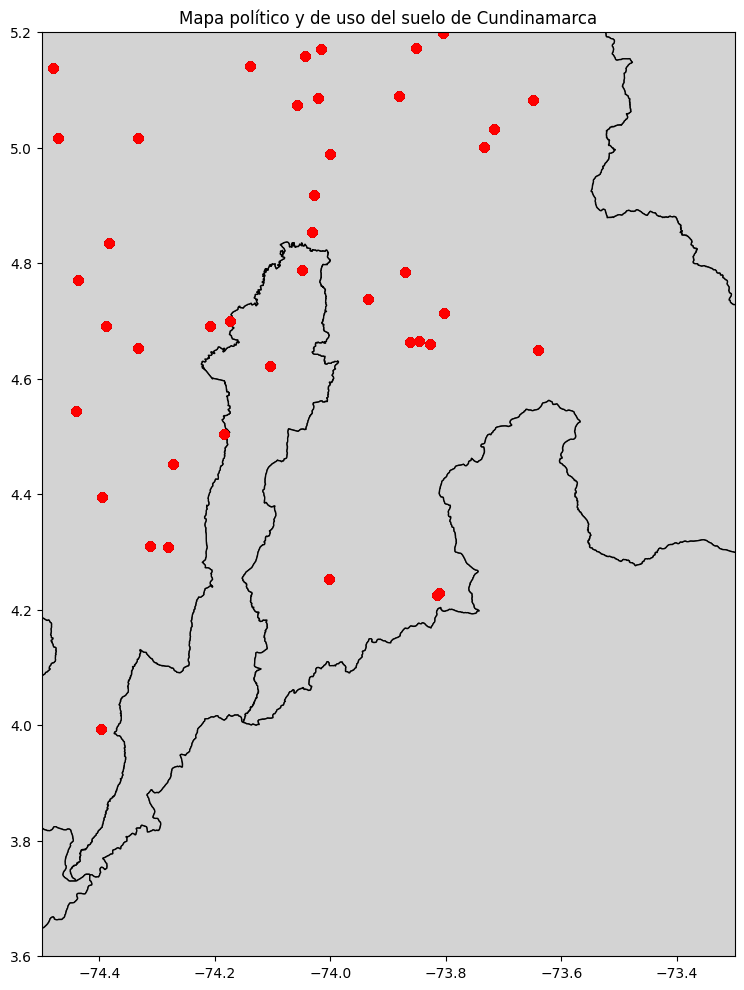

In [24]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Cargar el mapa de Cundinamarca
cundinamarca = gpd.read_file("MGN2021_DPTO_POLITICO/MGN_DPTO_POLITICO.shp")

# Cargar el mapa de uso del suelo de Cundinamarca
uso_suelo_cundinamarca = gpd.read_file("CUNDINAMARCA_SUELOS_VF/CUNDINAMARCA_SUELOS_VF.shp")

# Visualizar el mapa de Cundinamarca y el mapa de uso del suelo
fig, ax = plt.subplots(figsize=(12, 12))
cundinamarca.plot(ax=ax, color='lightgray', edgecolor='black')
uso_suelo_cundinamarca.plot(ax=ax, alpha=0.5, legend=True)
ax.set_title('Mapa político y de uso del suelo de Cundinamarca')
ax.set_xlim([-74.5, -73.3])  # Ajustar los límites de longitud
ax.set_ylim([3.6, 5.2])      # Ajustar los límites de latitud

# Superponer los puntos que representan las ubicaciones de las estaciones climáticas
ax.scatter(df['longitud'], df['latitud'], color='red', label='Estaciones climáticas', alpha=0.6)

# Añadir leyenda para el mapa de uso del suelo
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15, 1))

ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.legend()
plt.show()


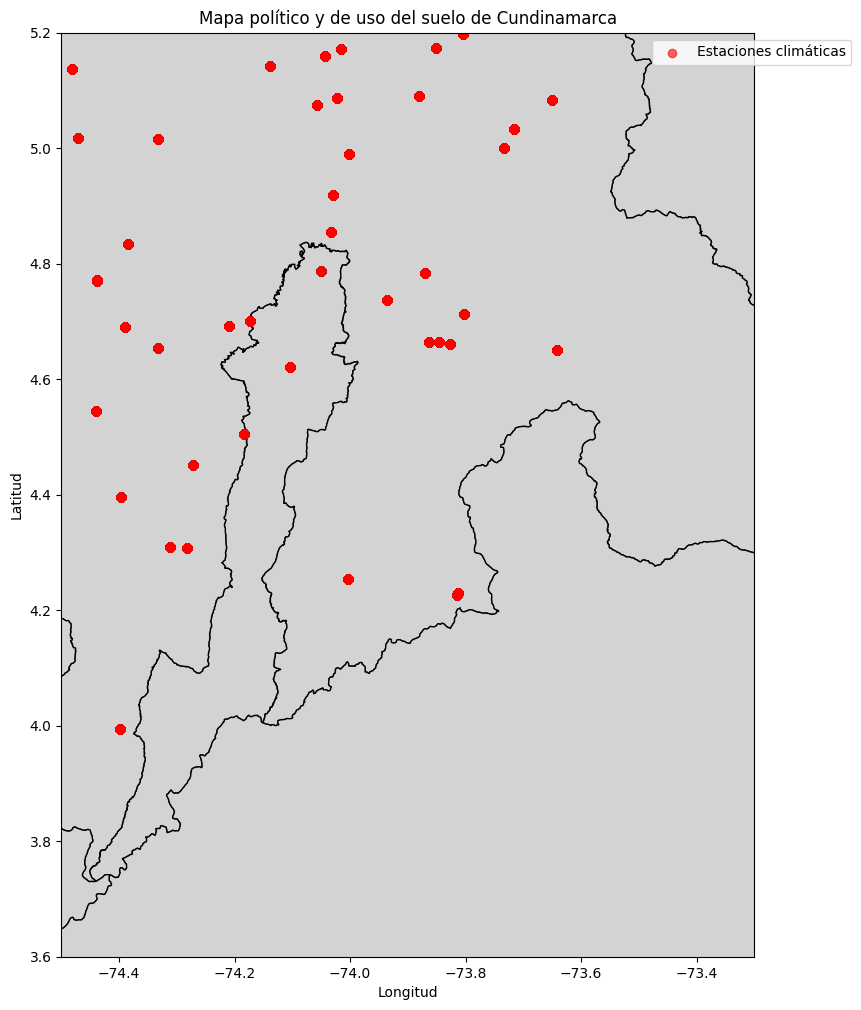

In [25]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Cargar el mapa de Cundinamarca
cundinamarca = gpd.read_file("MGN2021_DPTO_POLITICO/MGN_DPTO_POLITICO.shp")

# Cargar el mapa de uso del suelo de Cundinamarca
uso_suelo_cundinamarca = gpd.read_file("CUNDINAMARCA_SUELOS_VF/CUNDINAMARCA_SUELOS_VF.shp")

# Visualizar el mapa de Cundinamarca y el mapa de uso del suelo
fig, ax = plt.subplots(figsize=(12, 12))
cundinamarca.plot(ax=ax, color='lightgray', edgecolor='black')
uso_suelo_cundinamarca.plot(ax=ax, alpha=0.5, legend=True)
ax.set_title('Mapa político y de uso del suelo de Cundinamarca')
ax.set_xlim([-74.5, -73.3])  # Ajustar los límites de longitud
ax.set_ylim([3.6, 5.2])      # Ajustar los límites de latitud

# Superponer los puntos que representan las ubicaciones de las estaciones climáticas
ax.scatter(df['longitud'], df['latitud'], color='red', label='Estaciones climáticas', alpha=0.6)

# Ajustar posición de la leyenda
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
plt.show()


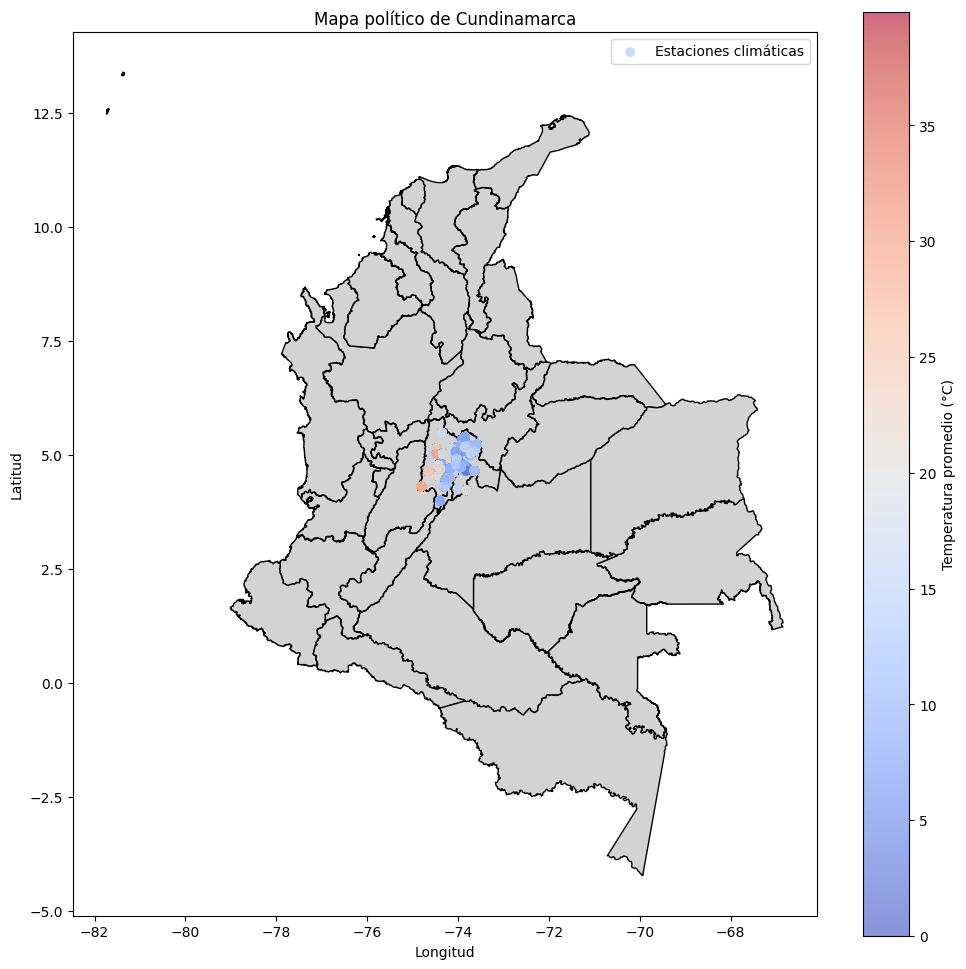

In [28]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Cargar el mapa de Cundinamarca
cundinamarca = gpd.read_file("MGN2021_DPTO_POLITICO/MGN_DPTO_POLITICO.shp")

# Visualizar el mapa de Cundinamarca
fig, ax = plt.subplots(figsize=(12, 12))
cundinamarca.plot(ax=ax, color='lightgray', edgecolor='black')
ax.set_title('Mapa político de Cundinamarca')

# Asignar colores a los puntos según el promedio de temperatura
# Utilizaremos el mapa de color 'coolwarm' para representar la temperatura
sc = ax.scatter(df['longitud'], df['latitud'], c=df['valorobservado'], cmap='coolwarm', alpha=0.6, label='Estaciones climáticas')

# Añadir barra de color
plt.colorbar(sc, label='Temperatura promedio (°C)')

ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


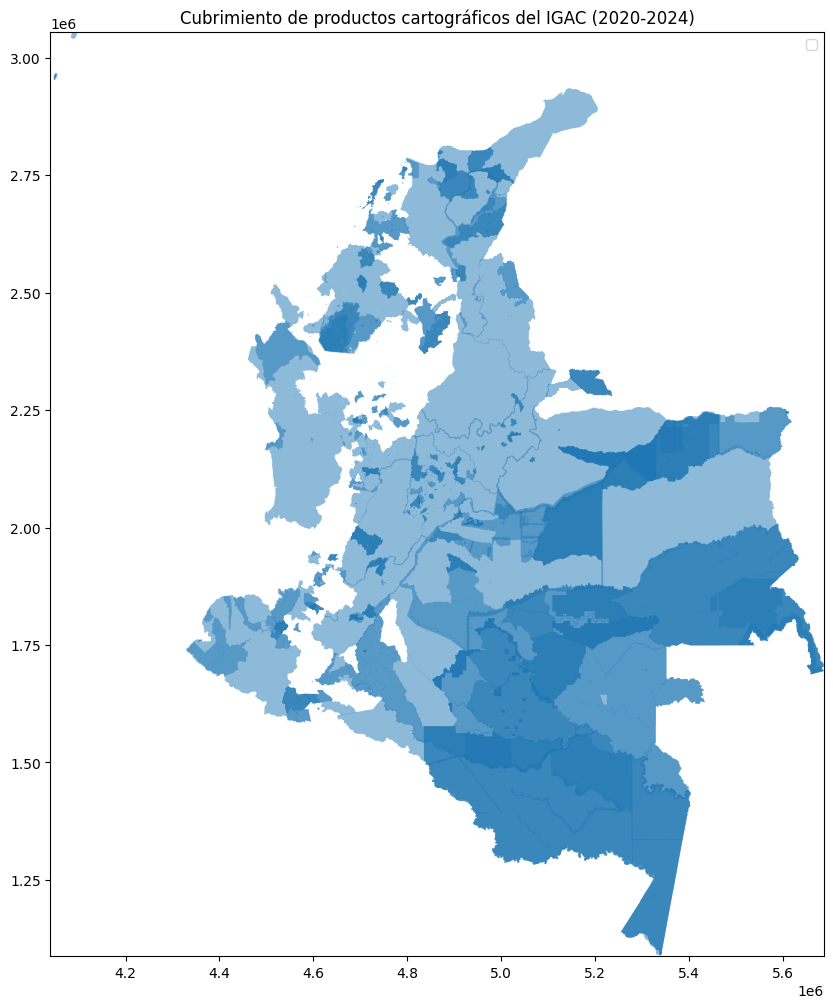

In [37]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Cargar el cubrimiento de productos cartográficos del IGAC
productos_igac = gpd.read_file("Servicio-90/ProductosFinal_2020_2024.shp")

# Visualizar el mapa de productos cartográficos
fig, ax = plt.subplots(figsize=(12, 12))
productos_igac.plot(ax=ax, alpha=0.5, legend=True)
ax.set_title('Cubrimiento de productos cartográficos del IGAC (2020-2024)')

# Ajustar los límites de los ejes según el cubrimiento de productos
ax.set_xlim([productos_igac.total_bounds[0], productos_igac.total_bounds[2]])  # Ajustar los límites de longitud
ax.set_ylim([productos_igac.total_bounds[1], productos_igac.total_bounds[3]])  # Ajustar los límites de latitud

# Agregar barra de leyenda
plt.legend()
plt.show()


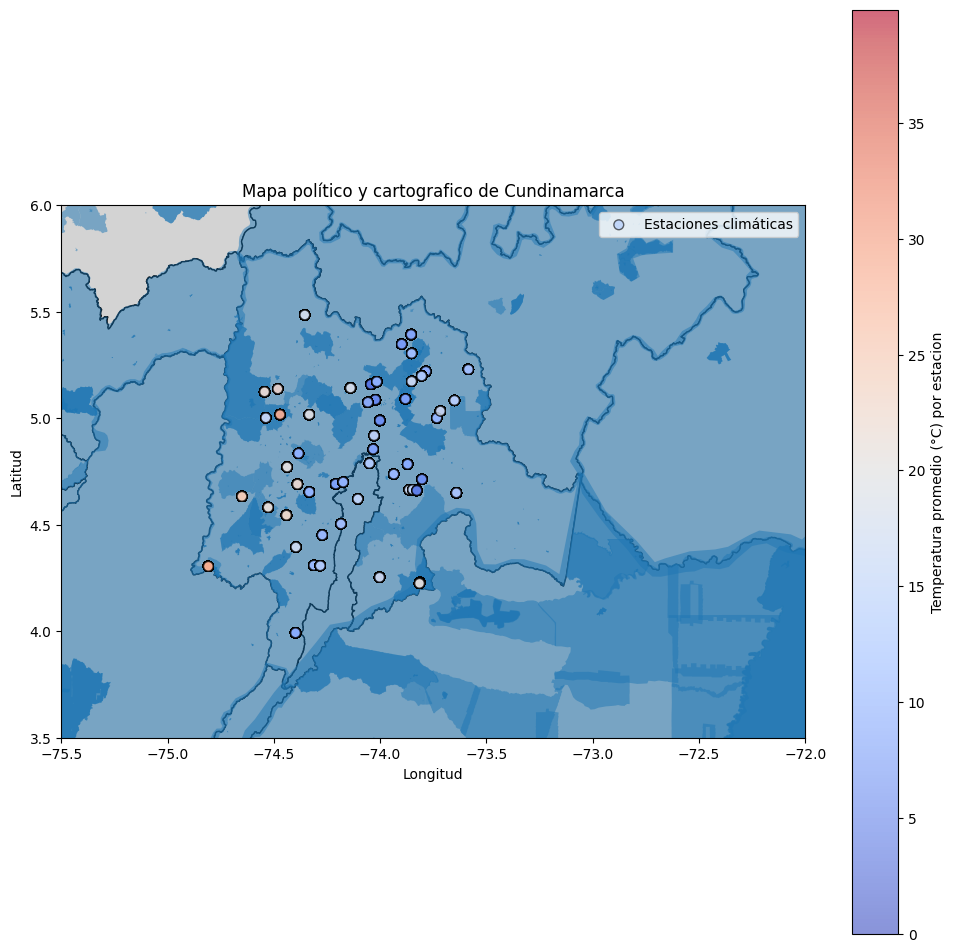

In [43]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Cargar el mapa de Cundinamarca
cundinamarca = gpd.read_file("MGN2021_DPTO_POLITICO/MGN_DPTO_POLITICO.shp")

# Cargar el cubrimiento de productos cartográficos del IGAC
productos_igac = gpd.read_file("Servicio-90/ProductosFinal_2020_2024.shp")

# Reproyectar el cubrimiento de productos del IGAC al EPSG:4686
productos_igac = productos_igac.to_crs(epsg=4686)

# Visualizar el mapa centrado en Cundinamarca
fig, ax = plt.subplots(figsize=(12, 12))
cundinamarca.plot(ax=ax, color='lightgray', edgecolor='black')
productos_igac.plot(ax=ax, alpha=0.5, legend=True)
ax.set_title('Mapa político y cartografico de Cundinamarca')

# Ajustar los límites de los ejes para enfocar en Cundinamarca
ax.set_xlim([-75.5, -72.0])  # Ajustar los límites de longitud
ax.set_ylim([3.5, 6.0])      # Ajustar los límites de latitud

# Asignar colores a los puntos según el promedio de temperatura
sc = ax.scatter(df['longitud'], df['latitud'], c=df['valorobservado'], cmap='coolwarm', alpha=0.6, label='Estaciones climáticas', edgecolor='black', linewidth=1)

# Ajustar el tamaño de los puntos
sc.set_sizes([50])

# Añadir barra de color
plt.colorbar(sc, label='Temperatura promedio (°C) por estacion')

ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.legend()
plt.show()


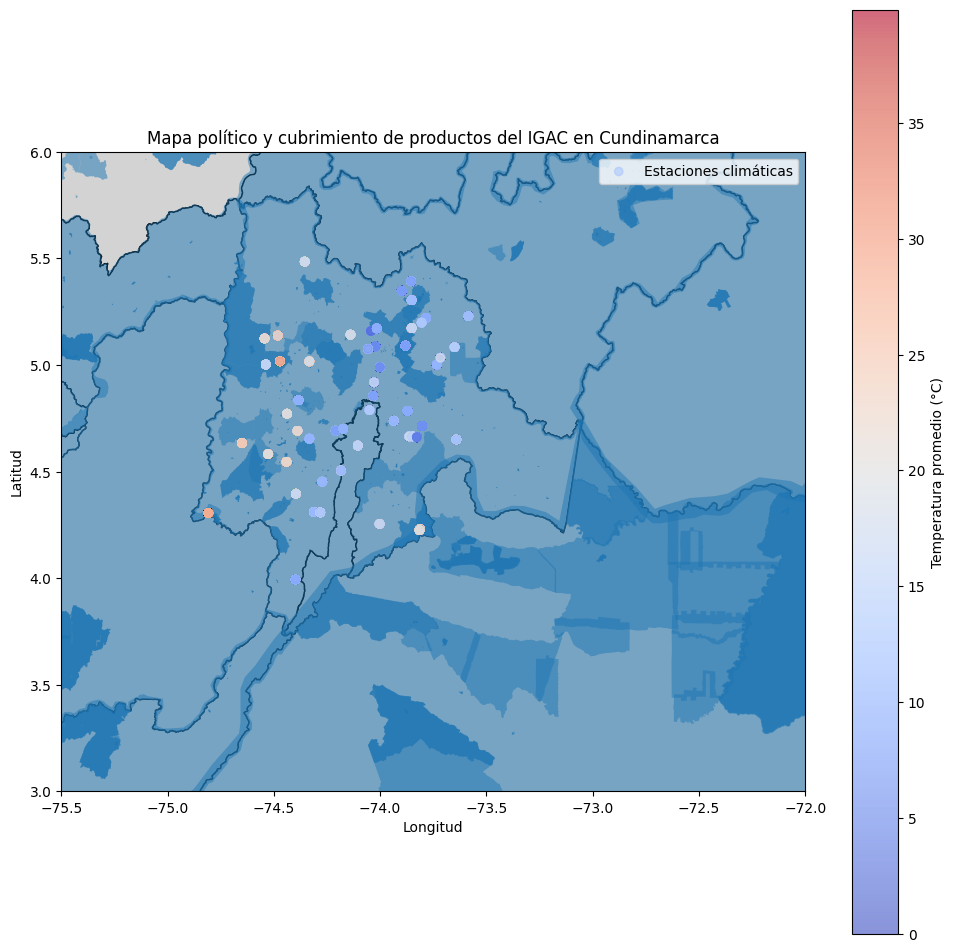

In [40]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Cargar el mapa de Cundinamarca
cundinamarca = gpd.read_file("MGN2021_DPTO_POLITICO/MGN_DPTO_POLITICO.shp")

# Cargar el cubrimiento de productos cartográficos del IGAC
productos_igac = gpd.read_file("Servicio-90/ProductosFinal_2020_2024.shp")

# Reproyectar el cubrimiento de productos del IGAC al EPSG:4686
productos_igac = productos_igac.to_crs(epsg=4686)

# Visualizar el mapa centrado en Cundinamarca
fig, ax = plt.subplots(figsize=(12, 12))
cundinamarca.plot(ax=ax, color='lightgray', edgecolor='black')
productos_igac.plot(ax=ax, alpha=0.5, legend=True)
ax.set_title('Mapa político y cubrimiento de productos del IGAC en Cundinamarca')

# Ajustar los límites de los ejes para enfocar en Cundinamarca
ax.set_xlim([-75.5, -72.0])  # Ajustar los límites de longitud
ax.set_ylim([3.0, 6.0])      # Ajustar los límites de latitud

# Asignar colores a los puntos según el promedio de temperatura
sc = ax.scatter(df['longitud'], df['latitud'], c=df['valorobservado'], cmap='coolwarm', alpha=0.6, label='Estaciones climáticas')

# Añadir barra de color
plt.colorbar(sc, label='Temperatura promedio (°C)')

ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.legend()
plt.show()


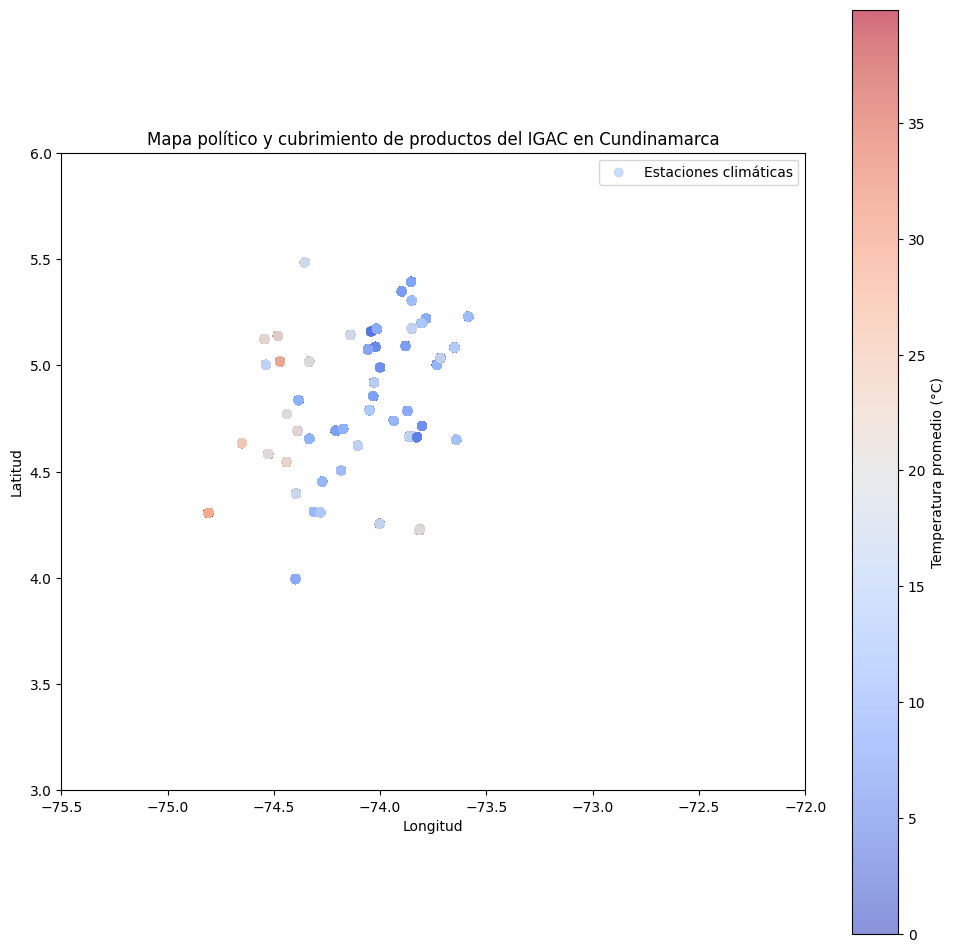

In [38]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Cargar el mapa de Cundinamarca
cundinamarca = gpd.read_file("MGN2021_DPTO_POLITICO/MGN_DPTO_POLITICO.shp")

# Reproyectar el mapa de Cundinamarca al EPSG:9377
cundinamarca = cundinamarca.to_crs(epsg=9377)

# Cargar el cubrimiento de productos cartográficos del IGAC
productos_igac = gpd.read_file("Servicio-90/ProductosFinal_2020_2024.shp")

# Visualizar el mapa centrado en Cundinamarca
fig, ax = plt.subplots(figsize=(12, 12))
cundinamarca.plot(ax=ax, color='lightgray', edgecolor='black')
productos_igac.plot(ax=ax, alpha=0.5, legend=True)
ax.set_title('Mapa político y cubrimiento de productos del IGAC en Cundinamarca')

# Ajustar los límites de los ejes para enfocar en Cundinamarca
ax.set_xlim([-75.5, -72.0])  # Ajustar los límites de longitud
ax.set_ylim([3.0, 6.0])      # Ajustar los límites de latitud

# Asignar colores a los puntos según el promedio de temperatura
sc = ax.scatter(df['longitud'], df['latitud'], c=df['valorobservado'], cmap='coolwarm', alpha=0.6, label='Estaciones climáticas')

# Añadir barra de color
plt.colorbar(sc, label='Temperatura promedio (°C)')

ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.legend()
plt.show()



In [39]:
print(cundinamarca.crs)
print(productos_igac.crs)
print(cundinamarca.bounds)
print(productos_igac.bounds)



EPSG:9377
EPSG:9377
            minx          miny          maxx          maxy
0   4.544725e+06  2.157214e+06  4.902701e+06  2.540303e+06
1   4.754066e+06  2.691632e+06  4.812274e+06  2.785820e+06
2   4.838947e+06  1.970368e+06  4.890663e+06  2.092578e+06
3   4.649651e+06  2.331596e+06  4.917940e+06  2.752513e+06
4   4.815712e+06  2.072396e+06  5.116057e+06  2.337708e+06
5   4.676040e+06  2.088821e+06  4.819841e+06  2.196864e+06
6   4.632126e+06  1.480062e+06  5.194256e+06  1.882858e+06
7   4.451719e+06  1.664078e+06  4.694583e+06  1.926529e+06
8   4.875007e+06  2.406038e+06  5.012501e+06  2.758967e+06
9   4.612240e+06  2.370841e+06  4.803924e+06  2.603331e+06
10  4.790252e+06  1.970314e+06  4.994174e+06  2.203181e+06
11  4.460413e+06  1.997029e+06  4.667536e+06  2.519659e+06
12  4.596794e+06  1.729794e+06  4.843142e+06  1.982829e+06
13  4.927384e+06  2.706873e+06  5.205336e+06  2.935222e+06
14  4.786799e+06  2.545597e+06  4.940782e+06  2.812311e+06
15  4.785188e+06  1.736798e+06  5.21

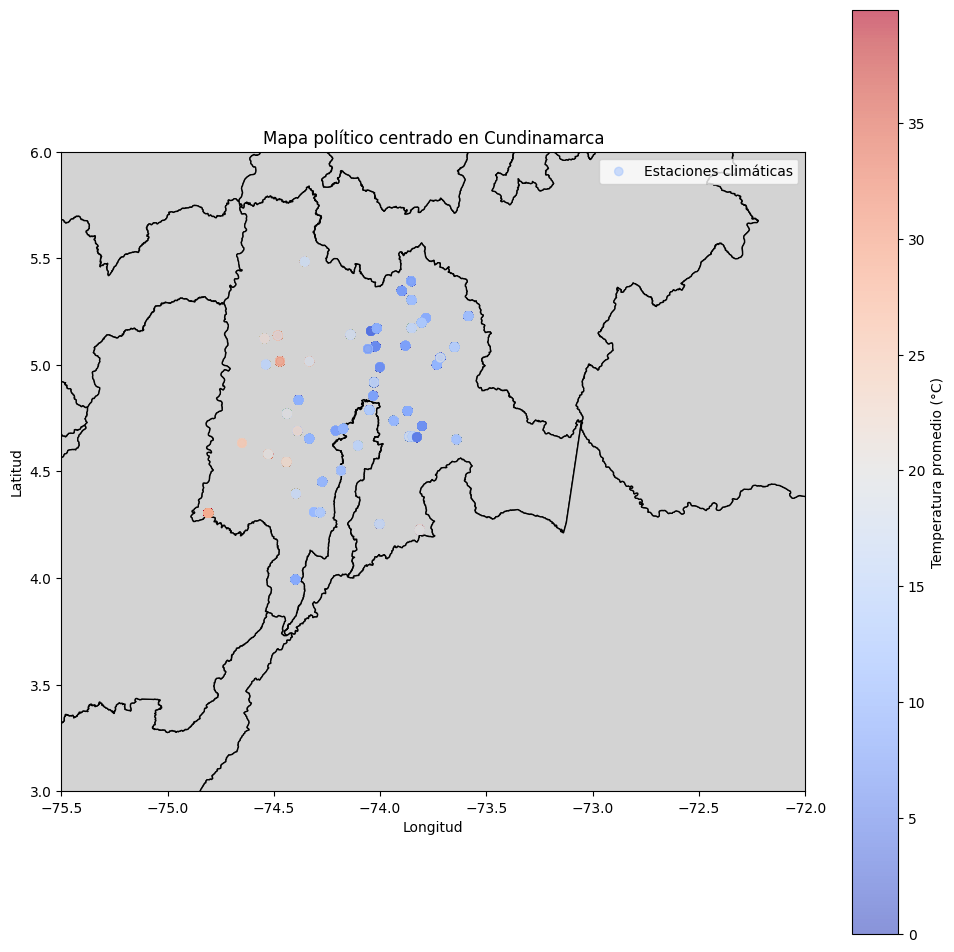

In [30]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Cargar el mapa de Cundinamarca
cundinamarca = gpd.read_file("MGN2021_DPTO_POLITICO/MGN_DPTO_POLITICO.shp")

# Visualizar el mapa centrado en Cundinamarca
fig, ax = plt.subplots(figsize=(12, 12))
cundinamarca.plot(ax=ax, color='lightgray', edgecolor='black')
ax.set_title('Mapa político centrado en Cundinamarca')

# Ajustar los límites de los ejes para enfocar en Cundinamarca
ax.set_xlim([-75.5, -72.0])  # Ajustar los límites de longitud
ax.set_ylim([3.0, 6.0])      # Ajustar los límites de latitud

# Asignar colores a los puntos según el promedio de temperatura
sc = ax.scatter(df['longitud'], df['latitud'], c=df['valorobservado'], cmap='coolwarm', alpha=0.6, label='Estaciones climáticas')

# Añadir barra de color
plt.colorbar(sc, label='Temperatura promedio (°C)')

ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.legend()
plt.show()


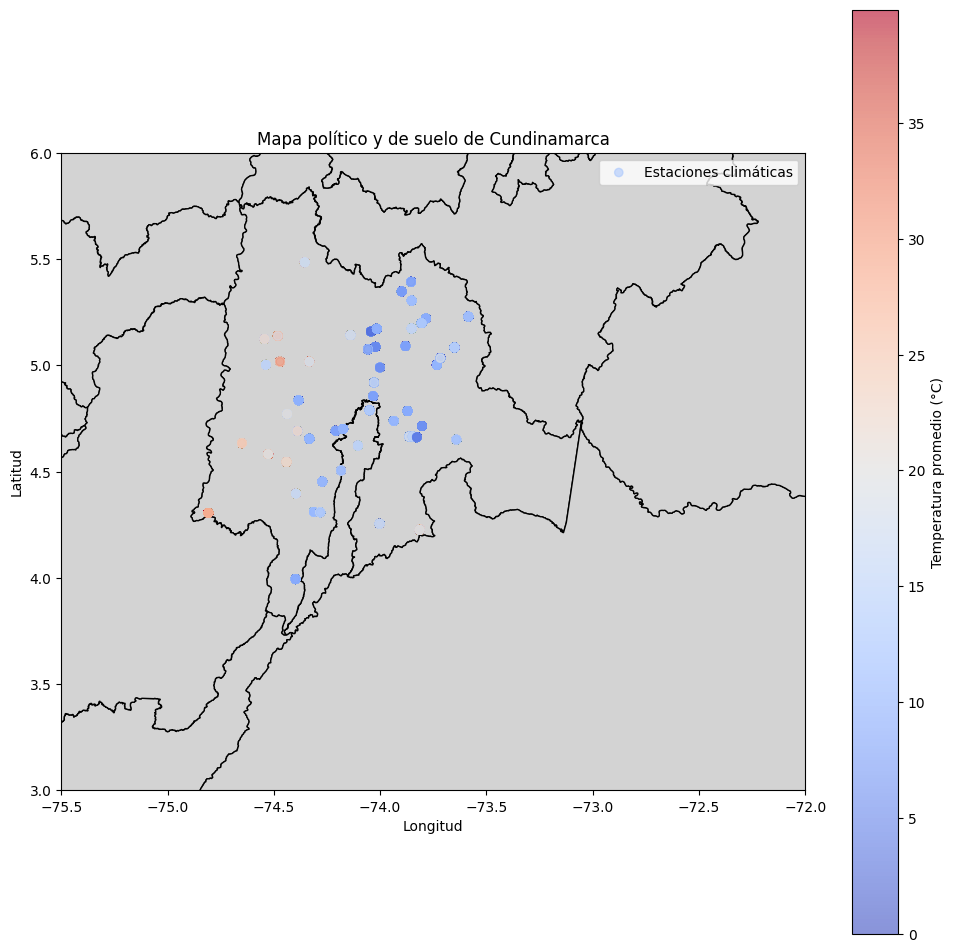

In [33]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Cargar el mapa de Cundinamarca
cundinamarca = gpd.read_file("MGN2021_DPTO_POLITICO/MGN_DPTO_POLITICO.shp")

# Cargar el mapa de uso del suelo de Cundinamarca
uso_suelo_cundinamarca = gpd.read_file("CUNDINAMARCA_SUELOS_VF/CUNDINAMARCA_SUELOS_VF.shp")

# Visualizar el mapa centrado en Cundinamarca
fig, ax = plt.subplots(figsize=(12, 12))
cundinamarca.plot(ax=ax, color='lightgray', edgecolor='black')
uso_suelo_cundinamarca.plot(ax=ax, alpha=0.5, legend=True)
ax.set_title('Mapa político y de suelo de Cundinamarca')

# Ajustar los límites de los ejes para enfocar en Cundinamarca
ax.set_xlim([-75.5, -72.0])  # Ajustar los límites de longitud
ax.set_ylim([3.0, 6.0])      # Ajustar los límites de latitud

# Asignar colores a los puntos según el promedio de temperatura
sc = ax.scatter(df['longitud'], df['latitud'], c=df['valorobservado'], cmap='coolwarm', alpha=0.6, label='Estaciones climáticas')

# Añadir barra de color
plt.colorbar(sc, label='Temperatura promedio (°C)')

ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.legend()
plt.show()


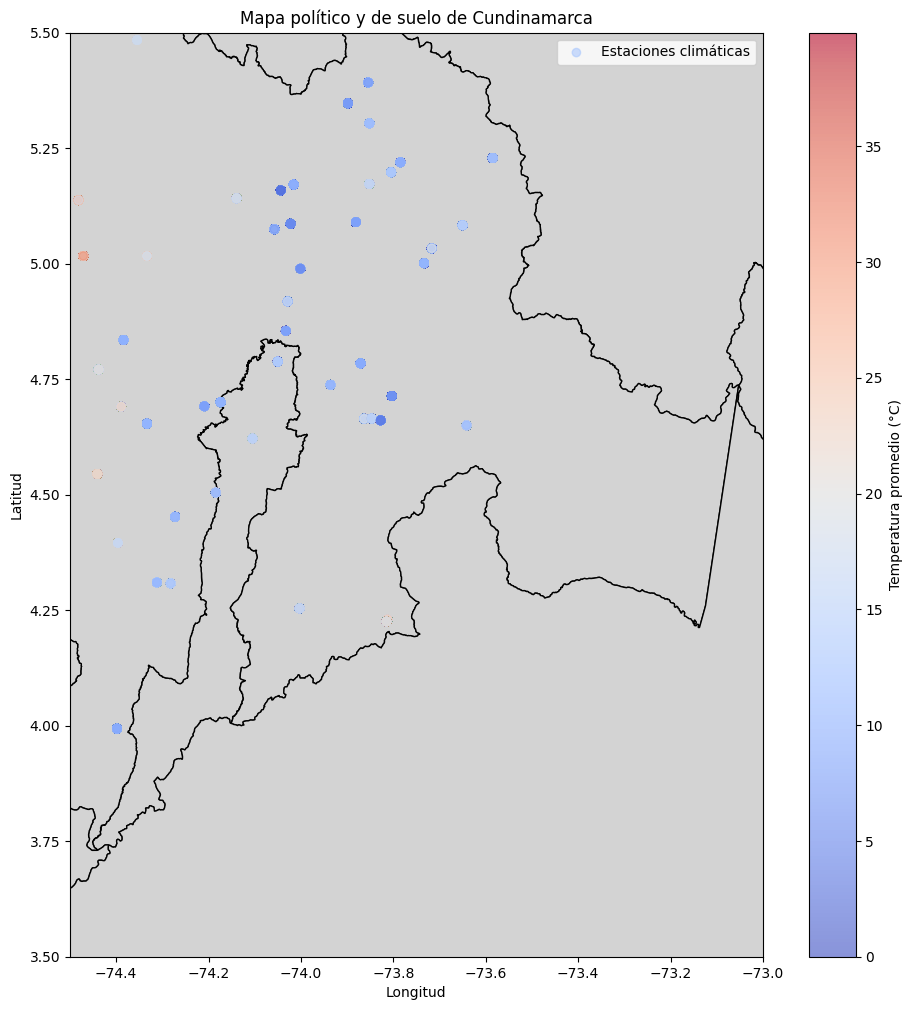

In [31]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Cargar el mapa de Cundinamarca
cundinamarca = gpd.read_file("MGN2021_DPTO_POLITICO/MGN_DPTO_POLITICO.shp")

# Cargar el mapa de uso del suelo de Cundinamarca
uso_suelo_cundinamarca = gpd.read_file("CUNDINAMARCA_SUELOS_VF/CUNDINAMARCA_SUELOS_VF.shp")

# Visualizar el mapa centrado en Cundinamarca
fig, ax = plt.subplots(figsize=(12, 12))
cundinamarca.plot(ax=ax, color='lightgray', edgecolor='black')
uso_suelo_cundinamarca.plot(ax=ax, alpha=0.5, legend=True)
ax.set_title('Mapa político y de suelo de Cundinamarca')

# Ajustar los límites de los ejes para enfocar en Cundinamarca
ax.set_xlim([-75.5, -72.0])  # Ajustar los límites de longitud
ax.set_ylim([3.0, 6.0])      # Ajustar los límites de latitud

# Asignar colores a los puntos según el promedio de temperatura
sc = ax.scatter(df['longitud'], df['latitud'], c=df['valorobservado'], cmap='coolwarm', alpha=0.6, label='Estaciones climáticas')

# Añadir barra de color
plt.colorbar(sc, label='Temperatura promedio (°C)')

ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.legend()
plt.show()


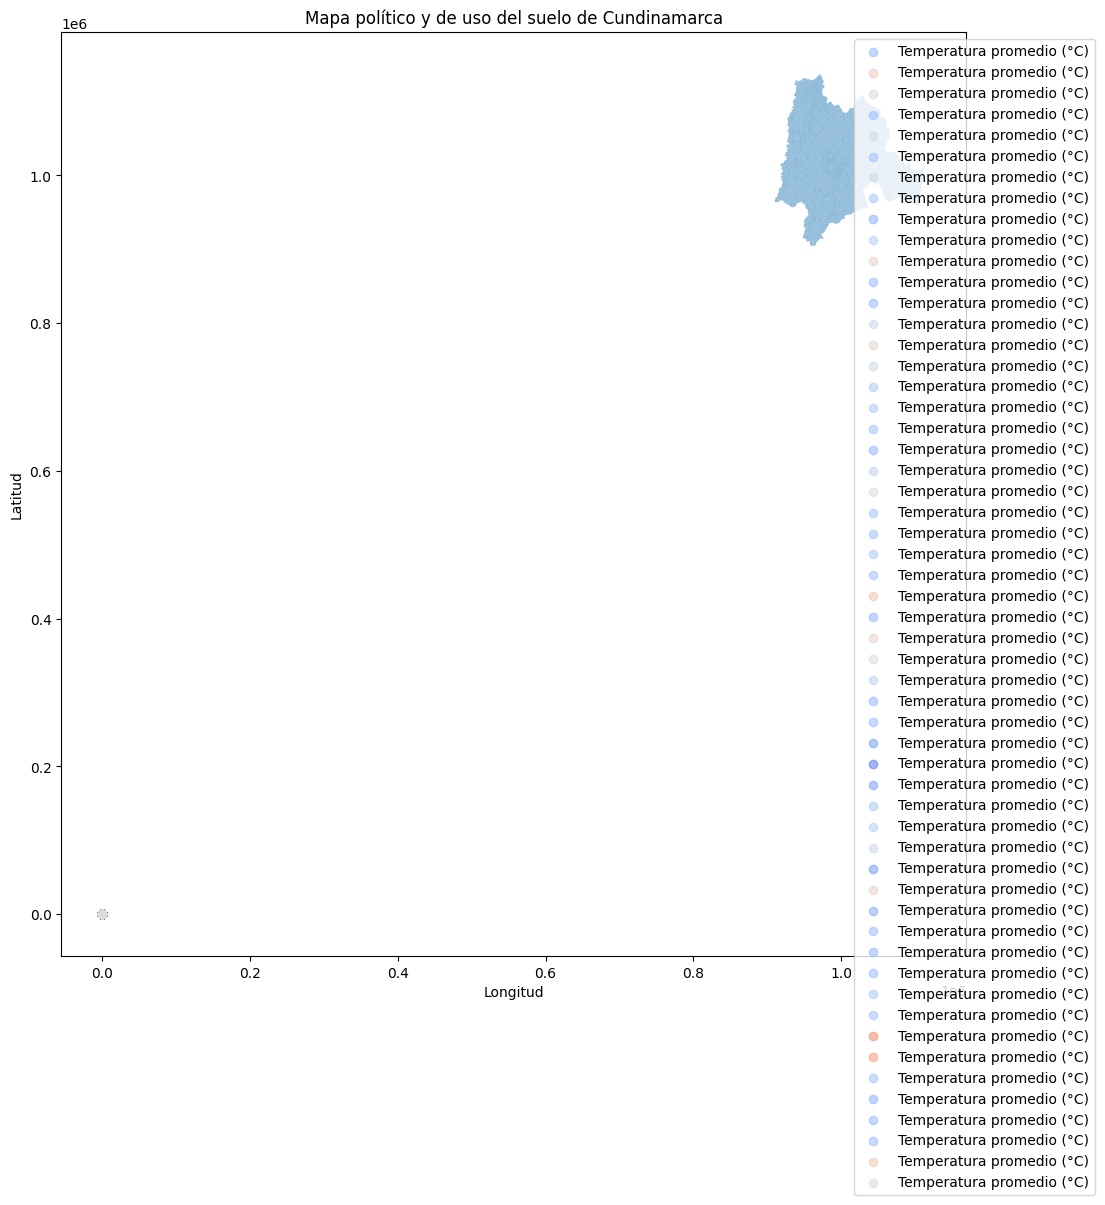

In [26]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Cargar el mapa de Cundinamarca
cundinamarca = gpd.read_file("MGN2021_DPTO_POLITICO/MGN_DPTO_POLITICO.shp")

# Cargar el mapa de uso del suelo de Cundinamarca
uso_suelo_cundinamarca = gpd.read_file("CUNDINAMARCA_SUELOS_VF/CUNDINAMARCA_SUELOS_VF.shp")

# Visualizar el mapa de Cundinamarca y el mapa de uso del suelo
fig, ax = plt.subplots(figsize=(12, 12))
cundinamarca.plot(ax=ax, color='lightgray', edgecolor='black')
uso_suelo_cundinamarca.plot(ax=ax, alpha=0.5, legend=True)
ax.set_title('Mapa político y de uso del suelo de Cundinamarca')

# Superponer los puntos que representan las ubicaciones de las estaciones climáticas
for estacion, promedio in promedio_temperatura_estacion.items():
    estacion_data = df[df['nombreestacion'] == estacion]
    ax.scatter(estacion_data['longitud'], estacion_data['latitud'], color=plt.cm.coolwarm(promedio / df['valorobservado'].max()), label='Temperatura promedio (°C)', alpha=0.6)

# Añadir leyenda para el mapa de uso del suelo
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
plt.show()




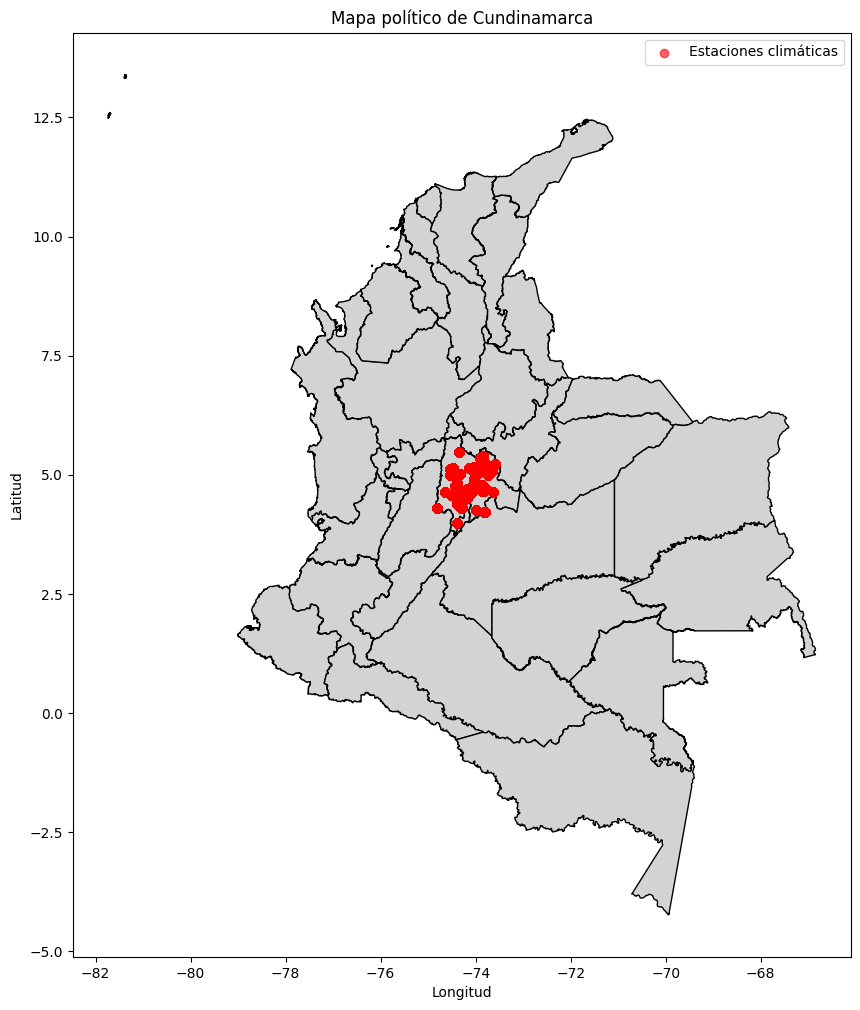

In [27]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Cargar el mapa de Cundinamarca
cundinamarca = gpd.read_file("MGN2021_DPTO_POLITICO/MGN_DPTO_POLITICO.shp")

# Visualizar el mapa de Cundinamarca
fig, ax = plt.subplots(figsize=(12, 12))
cundinamarca.plot(ax=ax, color='lightgray', edgecolor='black')
ax.set_title('Mapa político de Cundinamarca')

# Superponer los puntos que representan las ubicaciones de las estaciones climáticas
ax.scatter(df['longitud'], df['latitud'], color='red', label='Estaciones climáticas', alpha=0.6)

ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.legend()
plt.show()


## Identificación de correlaciones: 
-Utiliza métodos estadísticos para identificar correlaciones entre las diferentes variables. Por ejemplo, puedes calcular la matriz de correlación y visualizarla utilizando un mapa de calor.

In [28]:
# Calcula la matriz de correlación
correlation_matrix = df.corr()

# Visualiza la matriz de correlación utilizando un mapa de calor
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()


ValueError: could not convert string to float: 'GUAYABETAL POLLO OLIMPICO'